In [1]:
%run stdPackages.ipynb

# Social Security Design - Argentina

## 1. Input data and simple calibrations

We assume that we have data on the following:
* Worker-to-retiree ratios $\nu_t$.
* Capital income share $\alpha$.
* Frisch elasticity of labor $\xi$ (individual response to after-tax wages).
* Share of retirees that only receive basic pension benefits - here defined as share of hand-to-mouth households ($\gamma_u$).
* Heterogeneity in working households:
    1. Relative sizes of household types $\gamma_i$, such that $\sum_i = \gamma_i$.
    2. Income distribution across types $z_i^{\eta}$.
    3. Distribution of working hours across types $z_i^{x}$.
* The economy wide average savings rate $\overline{s}_t$.
* The ratio of income from $u$-types to the average worker for young ($\chi_1$) and old ($\chi_2$).
* The pension tax in a given year $\overline{\tau}$.
* The target for ratios of replacement rates for 1st and 2nd quartiles $RR$.

### 1.1. Fixed data

In [2]:
dates = pd.Index([1950, 1980, 2010, 2040, 2070, 2100], name = 't')
ν = np.array([1.497025777, 1.365562914, 1.20756547, 1.110843373, 1.072547602, 1.0725])
T = len(ν) # number of years in data
A = np.ones(T) # normalize exog. productivity at 1 
α = .43 # capital income share
ξ = .35 # frisch elasticity
γ = np.full((4, ), 0.25) # four equally large shares
ni = len(γ) # number of types of working households in this case
hours = np.array([38.6, 41.8, 43.4, 46.8]) # weekly hours, working households
income= np.array([618.6, 945.5, 1278.6, 2341.6]) # income levels, working households
zx = hours/hours.mean() # normalized data
zη = income/income.mean() # normalized data
γu =.32 # share of u households
χ1 = 0.3089 # relative income of u-types
χ2 = 0.95 * χ1 # relative income of u-types when old - assumed slightly lower
τ0 = 0.142 # target level of pension tax
s0 = 0.184 # target savings rate
t0date = 2010
t0 = dates.get_loc(t0date) # index for year of calibration 
RR = 0.678/0.803 # replacement rate

### 1.2. Calibration of $\eta_i, X_i, \theta$

1. The vector of $(\eta_i/X_i)^{\xi}$ is proportional to eigenvector $\textbf{y}^x$ - i.e. set $(\eta_i/X_i)^{\xi} = y_i^x$.
2. The vector of $(\eta_i^{1+\xi}/X_i^{\xi})$ is proportional to the eigenvector $\textbf{y}^{\eta}$ - i.e. set $\eta_i^{1+\xi}/X_i^{\xi} = k y_i^{\eta} $, where $k>0$ is some constant.
3. We then have $\eta_i =k y_i^{\eta} / y_i^x$ and $(\eta_i/X_i)^{\xi} = y_i^x$. Use $k$ to normalize such that 
$$\begin{align}
    \sum_i \gamma_i \eta_i^{1+\xi}/X_i^{\xi} = 1 \qquad \Rightarrow \qquad k = \dfrac{1}{\sum_i \gamma_i y_i^{\eta}}.
\end{align}$$

Find eigenvectors:

In [3]:
valx, vecx = scipy.sparse.linalg.eigs(zx.reshape(ni,1) * γ.reshape(1,ni), k=1)
valη, vecη = scipy.sparse.linalg.eigs(zη.reshape(ni,1) * γ.reshape(1,ni), k=1)
yx, yη = abs(np.real(vecx)).reshape(ni), abs(np.real(vecη)).reshape(ni) # this assumes that all coordinates in eigenvector are either positive or negative; this should be the case

Calibrate parameters:

In [4]:
η = yη/(yx*sum(γ*yη))
X = η/yx**(1/ξ)

Now given parameters that define household heterogeneity, we define $\theta$ from the relative replacement rates:

In [5]:
Q1 = η[0]**(1+ξ)/(X[0]**ξ)
Q2 = η[1]**(1+ξ)/(X[1]**ξ)
θ = (RR/Q1-1/Q2)/(1-RR+RR/Q1-1/Q2)

### 1.3. Initial guesses for yet-to-calibrated parameters

Set uniform $\beta$ for all types:

In [6]:
β = np.full(ni, fill_value = s0/(1-s0))
βu= min(β) # set impatience equal to lowest producticity household. 

Given our guess on $\beta$, we can define $\eps$ from the built-in function for the Argentina case: 

In [7]:
eps = logModelESC.argentinaCalEps(θ, β[0])

## 2. Initialize and solve model

We initialize the model with parameter values by calling:

In [8]:
model = logModelESC.infHorizon(ni = ni, T = T, **{'α': α, 'A': A, 'ν': ν, 'η': η, 'γ': γ, 'X': X, 'β': β, 'βu': βu, 'ξ': ξ, 'eps': eps, 'θ': θ, 'γu': γu, 'χ1': χ1, 'χ2': χ2})

Calibrate to the Argentina scenario:

In [9]:
model.argentinaCalibrate(τ0, s0, t0) # calibrate without endogenous political choice
model.argentinaCalibrate_preReform(τ0, s0, θ, t0) # calibrate with pol. choice

array([2.42056865, 0.28846538, 0.98560079, 0.50690036])

Add baseline solution to the database:

In [10]:
model.db.update(model.solve_ESC())
model.reportAll()

## 3. Baseline plots:

Provide some labels to call the $i$ types of agents when plotting:

In [11]:
typeLabels = {0: '1st Quartile', 1: '2nd Quartile', 2: '3rd Quartile', 3: '4th Quartile'}

Define a few auxiliary functions used for plotting:

In [12]:
def addYears(x, d, copy = True):
    """ Replace integer set 't' (from 0 to T) with years in 'dates' """
    if copy:
        x = x.copy()
    if isinstance(x, pd.Index):
        return x.map(pd.Series(d.values, index = x)).rename('')
    elif isinstance(x, (pd.DataFrame, pd.Series)):
        x.index = addYears(x.index, d, copy = False)
        return x
def adjLabels(x, copy = True):
    """ Replace integer set 'i' (from 0 to ni) with labels in 'typeLabels' """
    if copy:
        x = x.copy()
    if isinstance(x, pd.Index):
        return x.map(typeLabels)
    elif isinstance(x, pd.Series):
        x.index = adjLabels(x.index, copy = False)
    elif isinstance(x, pd.DataFrame):
        x.columns = adjLabels(x.columns, copy = False)
    return x
def extractDf(sol, x, grid, d):
    """ Collect data on variables from different simulations in one dataframe """
    return addYears(pd.concat([soli[x] for soli in sol.values()], axis=1), d).set_axis(grid, axis = "columns")    

### 3.1. PEE taxes, labor supply, savings, and worker-to-retiree ratio over time:

*Collect data:*

In [13]:
df = pd.concat([addYears(model.db[k].loc[0:], dates).rename(k) for k in ('τ', 'h')], axis = 1)
df['Worker-to-retiree ratio'] = pd.Series(model.db['ν'], index = dates)
df['Savings rate (% GDP)'] = addYears(model.savingsRate(model.db['Θs'], model.db['Θh']), dates) # savings rate as % of GDP

Normalize the $h$ variable to average indicate working hours, using that the level in 2010 is defined as:

In [14]:
hAverage_2010 = sum(γ * hours)
df['Avg. weekly working hours'] = df['h']/df['h'].xs(2010) * hAverage_2010

*Plot:*

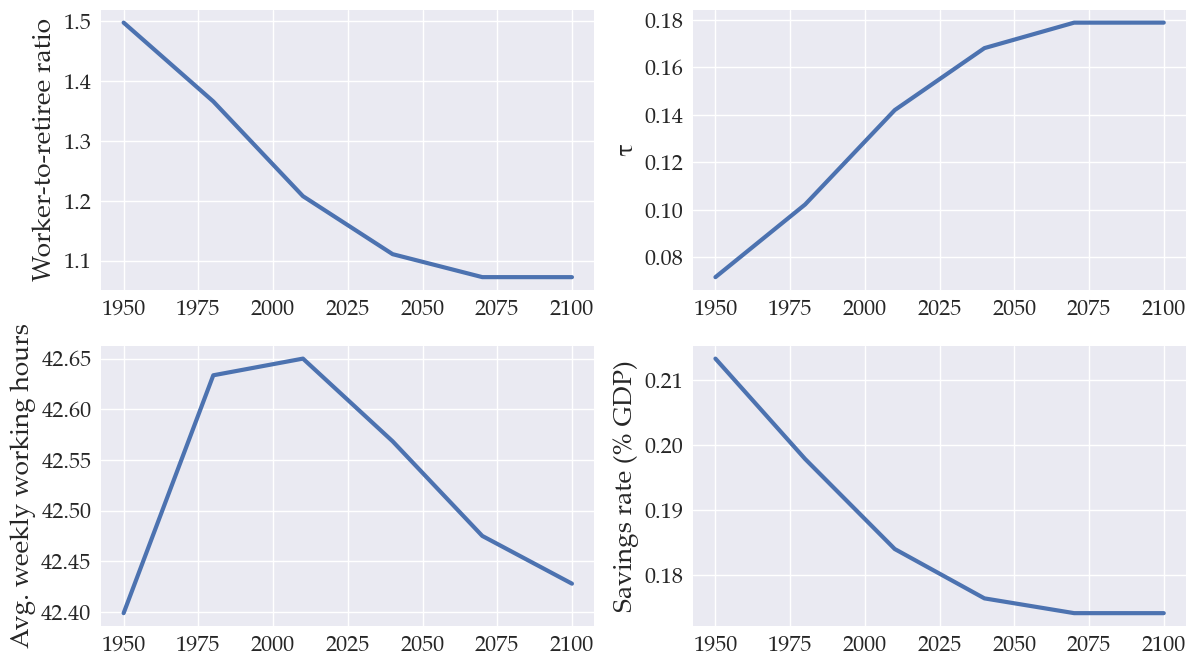

In [15]:
mult_graphs()
fig, axes = plt.subplots(2, 2, figsize = (14,8));
ite = ('Worker-to-retiree ratio','τ','Avg. weekly working hours','Savings rate (% GDP)');
for j in range(len(ite)):
    ax = plt.subplot(2,2,j+1);
    seaborn.lineplot(data = df[ite[j]], linewidth = 3, ax = ax, legend = True);
fig.savefig(os.path.join(d['figs'], 'baseline_Argentina.pdf'), edgecolor='k')

### 3.2. Inequality in savings, working hours, and consumption:

Present variation in savings and labor income in baseline year:

In [16]:
s_ineq = adjLabels(model.db['Θsi'].div(model.db['Θs'], axis = 0).xs(t0)) # savings
h_ineq = adjLabels(model.db['Θhi'].div(model.db['Θh'], axis = 0).xs(t0)) # labor income

Plot:

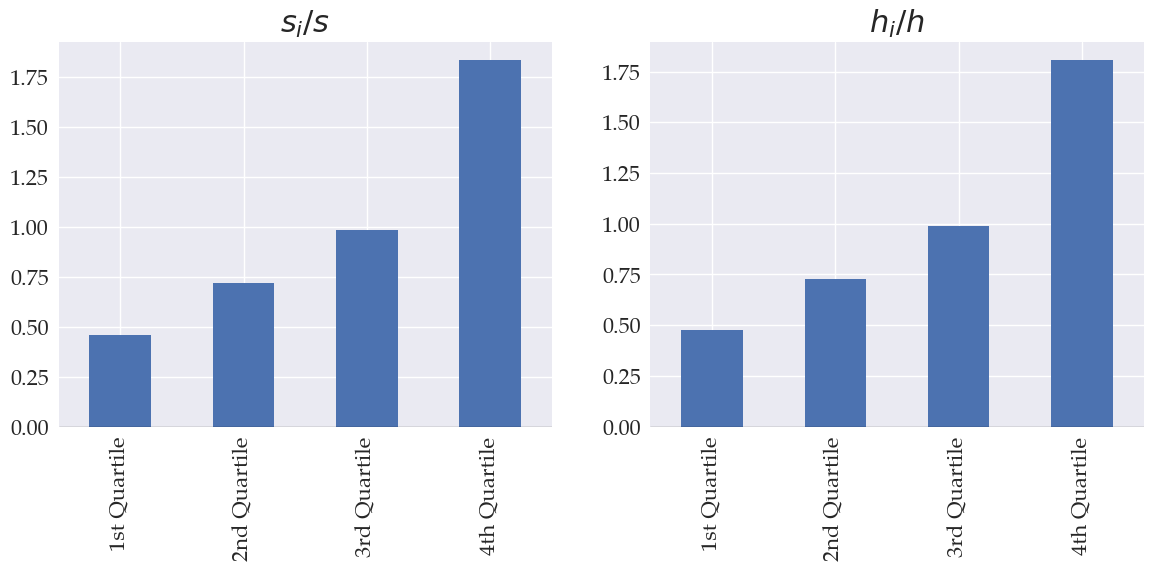

In [17]:
mult_graphs()
fig, axes = plt.subplots(1,2,figsize = (14,5));
ax = plt.subplot(1,2,1)
s_ineq.plot.bar(ax = ax);
dfAx(ax, ylabel = None);
ax.set_xlabel('');
ax.set_title('$s_i / s$');
ax = plt.subplot(1,2,2)
h_ineq.plot.bar(ax = ax);
dfAx(ax, ylabel = None);
ax.set_xlabel('');
ax.set_title('$h_i / h$');
fig.savefig(os.path.join(d['figs'], 'baseline_Ineq1_Argentina.pdf'), edgecolor='k')

## 4. Adjusting parameters to reflect pension reform

Store baseline solution before comparisons:

In [18]:
initialSolution = model.db.copy() # default values to start experiments from

The unexpected changes arrive in 2010. The easiest way to introduce this is to initialize a new model that runs from 2010-2100:

In [19]:
dates_2010 = dates[dates>=2010]
T_2010 = len(dates_2010)
model_2010 = logModelESC.infHorizon(ni = ni, T = T_2010, 
                                    eps = model.db['eps'].loc[t0:].set_axis(model.db['t'][t0:]-t0), 
                                    θ = model.db['θ'].loc[t0:].set_axis(model.db['t'][t0:]-t0),
                                    **({k: initialSolution[k] for k in model.defaultParameters} | {'ν': ν[(T-T_2010):],
                                                                                           'A': A[(T-T_2010):]}))

Solve and store the baseline solution with the shifted time index:

In [20]:
model_2010.updateSolve_ESC()
model_2010.reportAll(s_=initialSolution['s'][t0])
baseline = model_2010.db.copy()

### 4.1. Going to "basic" coverage

Now, calibrate the model to reflect the same $\theta$ and $\epsilon = 1-\theta$ after the reform:

In [21]:
model_2010.argentinaCalibrate_postReform(θ, 1-θ, 0)
model_2010.updateSolve_ESC()
model_2010.reportAll(s_= initialSolution['s'][t0])

dbBasicCoverage = model_2010.db.copy()

Print latex table:

In [22]:
τBase = round(baseline['τ'].xs(0)*100,1)
sBase = round(model_2010.savingsRate(baseline['Θs'].xs(0), baseline['Θh'].xs(0))*100,1)
hBase = round(sum(γ*hours), 2)
τBasicCoverage = round(dbBasicCoverage['τ'].xs(0)*100,1)
sBasicCoverage = round(model_2010.savingsRate(dbBasicCoverage['Θs'].xs(0), dbBasicCoverage['Θh'].xs(0))*100,1)
hBasicCoverage = round((dbBasicCoverage['h'].xs(0)/baseline['h'].xs(0)) * hBase, 2)

Print latex code for table:

In [23]:
def table1(τBase, sBase, hBase, ϵBase, θBase, τNew, sNew, hNew, ϵNew, θNew, name):
    return f"""
\\begin{{table}}[!htb]\centering
\caption{{Pension system reform, year 2010.}}
\label{{table:comparison}}
\\begin{{tabular}}{{p{{3.8cm}}p{{0.3cm}}cp{{0.3cm}}cp{{0.3cm}}c}}
\\\\[-1.8ex] \hline\hline \\\\[-1.8ex]
\\textbf{{Variable:}} & & \\textbf{{Tax rate}} && \\textbf{{Savings rate}} && \\textbf{{Avg. workweek (hours)}} \\\\
\hline\\\\[-1ex]
Initial (\\textit{{B}})  && \multirow{{2}}{{*}}{{{τBase}\%}} && \multirow{{2}}{{*}}{{{sBase}\%}} && \multirow{{2}}{{*}}{{{hBase}}} \\\\[-0.5ex]
\small{{$(\eps$=${round(ϵBase,2)}$, $\\theta$=${round(θBase,2)}$)}} \\\\[1ex]
Universal (\\textit{{{name}}}) && \multirow{{2}}{{*}}{{{τNew}\%}} && \multirow{{2}}{{*}}{{{sNew}\%}} && \multirow{{2}}{{*}}{{{hNew}}} \\\\[-0.5ex]
\small{{$(\eps$=${round(ϵNew,2)}$, $\\theta$=${round(θNew,2)}$)}} &&&&&& \\\\[1ex]
\hline\hline\\\\[-1.8ex]
\end{{tabular}}
\caption*{{\\footnotesize{{Politico-economic equilibrium for social security under the initial regime and after making pension benefits universal.}}}} 
\end{{table}}
"""
print(table1(τBase, sBase, hBase, baseline['eps'].xs(0), baseline['θ'].xs(0), τBasicCoverage, sBasicCoverage, hBasicCoverage, 1-baseline['θ'].xs(0), baseline['θ'].xs(0), 'U'))


\begin{table}[!htb]\centering
\caption{Pension system reform, year 2010.}
\label{table:comparison}
\begin{tabular}{p{3.8cm}p{0.3cm}cp{0.3cm}cp{0.3cm}c}
\\[-1.8ex] \hline\hline \\[-1.8ex]
\textbf{Variable:} & & \textbf{Tax rate} && \textbf{Savings rate} && \textbf{Avg. workweek (hours)} \\
\hline\\[-1ex]
Initial (\textit{B})  && \multirow{2}{*}{14.2\%} && \multirow{2}{*}{18.4\%} && \multirow{2}{*}{42.65} \\[-0.5ex]
\small{$(\eps$=$0.1$, $\theta$=$0.72$)} \\[1ex]
Universal (\textit{U}) && \multirow{2}{*}{14.5\%} && \multirow{2}{*}{18.5\%} && \multirow{2}{*}{42.59} \\[-0.5ex]
\small{$(\eps$=$0.28$, $\theta$=$0.72$)} &&&&&& \\[1ex]
\hline\hline\\[-1.8ex]
\end{tabular}
\caption*{\footnotesize{Politico-economic equilibrium for social security under the initial regime and after making pension benefits universal.}} 
\end{table}



### 4.2. Going to "universal" coverage

Next, consider the effect of going to universal coverage

In [24]:
ϵMax   = initialSolution['θ'].xs(t0) * min(η) * initialSolution['hi'].xs(t0-1).xs(0) / initialSolution['h'].xs(t0-1) + 1-initialSolution['θ'].xs(t0)
model_2010.argentinaCalibrate_postReform(θ, ϵMax, 0)
model_2010.updateSolve_ESC()
model_2010.reportAll(s_=initialSolution['s'][t0])

dbU = model_2010.db.copy()

Get data:

In [25]:
τU = round(dbU['τ'].xs(0)*100,1)
sU = round(model_2010.savingsRate(dbU['Θs'].xs(0), dbU['Θh'].xs(0))*100,1)
hU = round((dbU['h'].xs(0)/baseline['h'].xs(0)) * hBase, 2)
print(table1(τBase, sBase, hBase, baseline['eps'].xs(0), baseline['θ'].xs(0), τU, sU, hU, ϵMax, baseline['θ'].xs(0), 'U'))


\begin{table}[!htb]\centering
\caption{Pension system reform, year 2010.}
\label{table:comparison}
\begin{tabular}{p{3.8cm}p{0.3cm}cp{0.3cm}cp{0.3cm}c}
\\[-1.8ex] \hline\hline \\[-1.8ex]
\textbf{Variable:} & & \textbf{Tax rate} && \textbf{Savings rate} && \textbf{Avg. workweek (hours)} \\
\hline\\[-1ex]
Initial (\textit{B})  && \multirow{2}{*}{14.2\%} && \multirow{2}{*}{18.4\%} && \multirow{2}{*}{42.65} \\[-0.5ex]
\small{$(\eps$=$0.1$, $\theta$=$0.72$)} \\[1ex]
Universal (\textit{U}) && \multirow{2}{*}{14.9\%} && \multirow{2}{*}{18.6\%} && \multirow{2}{*}{42.49} \\[-0.5ex]
\small{$(\eps$=$0.64$, $\theta$=$0.72$)} &&&&&& \\[1ex]
\hline\hline\\[-1.8ex]
\end{tabular}
\caption*{\footnotesize{Politico-economic equilibrium for social security under the initial regime and after making pension benefits universal.}} 
\end{table}



## 5. Look at changing values of $\epsilon, \theta$ exogenously to understand mechanisms

Next, we very $\epsilon$ and $\theta$ exogenously (and only look at endogenous policies), to get an idea of how parameters interact. Before doing any shocks, we reset calibrated parameter values to pre-reform levels:

In [26]:
model_2010.db['ωu'], model_2010.db['ωη'] = baseline['ωu'], baseline['ωη']

## 5.1. Define a "standard" shock

Whenever we do one of these shocks to a parameter, e.g. $\epsilon$, we want to do some of the same things:
1. Update parameter values in active model. 
2. Solve and store PEE solution.
3. Solve and store equivalent variations.
4. Reset taxes to some baseline value and solve for counterfactual equilibrium (what is the effect of parameter changes *given* fixed tax rates). Store this as well.

In [27]:
def parameterShock(model, parameterDict, baseline):
    # solve with new parameters
    model.updateSolve_PEE(**parameterDict)
    model.reportAll(s_ = baseline['s'].iloc[0]) 
    # compute EV and store solution in 'sol'
    EV = model.ns['EV'].unloadSol(model.solve_EV_Permanent(baseline, model.db))
    sol = (model.db | model.EV_solInPercentages(baseline, EV)).copy()
    
    # Reset tax rates to compute counterfactual solution:
    [model.db.__setitem__(k, baseline[k].copy()) for k in ('τ', 'τ[t+1]')];
    model.db.update(model.solve_EE(model.db['τ'], model.db['τ[t+1]'], model.db['eps[t+1]'], model.db['θ[t+1]']))
    model.reportAll(s_ = baseline['s'].iloc[0])
    sol_cf = model.db.copy()
    # Compute EV for this scenario as well
    EV = model.ns['EV'].unloadSol(model.solve_EV_Permanent(baseline, model.db))
    sol_cf.update(model.EV_solInPercentages(baseline, EV))
    return sol, sol_cf

## 5.2. Simulate effects of gradually changing $\epsilon$ and $\theta$.

Consider varying $\epsilon$ between $0-\epsilon_{max}$ for $\theta\in[0, 1]$. We define: $\epsilon_{max} \equiv \theta \underline{\eta}\underline{h}_{t-1}/h_{t-1}+1-\theta$.

In [28]:
ϵMax   = initialSolution['θ'].xs(t0) * min(η) * initialSolution['hi'].xs(t0-1).xs(0) / initialSolution['h'].xs(t0-1) + 1-initialSolution['θ'].xs(t0)
ϵgrid  = pd.Index([round(x,2) for x in np.linspace(0,ϵMax,6)], name = '$\eps$').insert(0, 1-baseline['θ'].xs(0)).sort_values()
ϵgrid_ = ϵgrid.insert(0, baseline['eps'].xs(0)) 
θgrid  = pd.Index([round(x,2) for x in np.linspace(0,1,6)], name = '$\\theta$')
θgrid_ = θgrid.insert(0, baseline['θ'].xs(0))
idx  = pd.MultiIndex.from_product([θgrid, ϵgrid])
idx_ = pd.MultiIndex.from_product([θgrid_, ϵgrid_])
sol = dict.fromkeys(idx_)
sol_cf = dict.fromkeys(idx_)

Start by identifying a baseline solution with the baseline value of $\epsilon$ and different $\theta$ values. Now, loop over $\epsilon$ values and solve and compare to the relevant baseline:

In [29]:
%%time
for θ, ϵ in sol:
    sol[(θ, ϵ)], sol_cf[(θ,ϵ)] = parameterShock(model_2010, model_2010.initSC(ϵ, 'eps') | model_2010.initSC(θ, 'θ'), baseline)

CPU times: total: 1min 21s
Wall time: 1min 21s


## 5.3. What are the effects of going to a purely universal system.

As a function of going from $\epsilon_{base}$ to $\epsilon_{max}$, what is the effect on: 
1. PEE taxes.
2. Savings rate.
3. Labor supply.

In [30]:
solU = sol[(baseline['θ'].xs(0), max(ϵgrid))]
τU    = round(solU['τ'].xs(0)*100,1)
sU    = round((solU['Θs']/((1-solU['α'])*(solU['Θh']**(1-solU['α'])))).xs(0)*100,1)
hU    = round((solU['h'].xs(0) / baseline['h'].xs(0)) * hBase, 2)

Print latex code for table:

In [31]:
print(table1(τBase, sBase, hBase, baseline['eps'].xs(0), baseline['θ'].xs(0), τU, sU, hU, max(ϵgrid), baseline['θ'].xs(0), 'U'))


\begin{table}[!htb]\centering
\caption{Pension system reform, year 2010.}
\label{table:comparison}
\begin{tabular}{p{3.8cm}p{0.3cm}cp{0.3cm}cp{0.3cm}c}
\\[-1.8ex] \hline\hline \\[-1.8ex]
\textbf{Variable:} & & \textbf{Tax rate} && \textbf{Savings rate} && \textbf{Avg. workweek (hours)} \\
\hline\\[-1ex]
Initial (\textit{B})  && \multirow{2}{*}{14.2\%} && \multirow{2}{*}{18.4\%} && \multirow{2}{*}{42.65} \\[-0.5ex]
\small{$(\epsilon$=$0.1$, $\theta$=$0.72$)} \\[1ex]
Universal (\textit{U}) && \multirow{2}{*}{13.4\%} && \multirow{2}{*}{19.3\%} && \multirow{2}{*}{42.64} \\[-0.5ex]
\small{$(\epsilon$=$0.64$, $\theta$=$0.72$)} &&&&&& \\[1ex]
\hline\hline\\[-1.8ex]
\end{tabular}
\caption*{\footnotesize{Politico-economic equilibrium for social security under the initial regime and after making pension benefits universal.}} 
\end{table}



## 5.4. What are the effects of going to universal system with "basic coverage":

As a function of going from $\epsilon_{base}$ to $1-\theta$, what is the effect on: 
1. PEE taxes.
2. Savings rate.
3. Labor supply.

Get tax rates:

In [34]:
solBasicCoverage = sol[(baseline['θ'].xs(0), 1-baseline['θ'].xs(0))]
τBasicCoverage = round(solBasicCoverage['τ'].xs(0)*100,1)

Get savings rates:

In [35]:
sBasicCoverage  = round((solBasicCoverage['Θs']/((1-solBasicCoverage['α'])*(solBasicCoverage['Θh']**(1-solBasicCoverage['α'])))).xs(0)*100,1)

Average hours worked:

In [36]:
hBasicCoverage   = round((solBasicCoverage['h'].xs(0) / baseline['h'].xs(0)) * hBase, 2)

Print latex code for table:

In [37]:
print(table1(τBase, sBase, hBase, baseline['eps'].xs(0), baseline['θ'].xs(0), τBasicCoverage, sBasicCoverage, hBasicCoverage, 1-baseline['θ'].xs(0), baseline['θ'].xs(0), 'U'))


\begin{table}[!htb]\centering
\caption{Pension system reform, year 2010.}
\label{table:comparison}
\begin{tabular}{p{3.8cm}p{0.3cm}cp{0.3cm}cp{0.3cm}c}
\\[-1.8ex] \hline\hline \\[-1.8ex]
\textbf{Variable:} & & \textbf{Tax rate} && \textbf{Savings rate} && \textbf{Avg. workweek (hours)} \\
\hline\\[-1ex]
Initial (\textit{B})  && \multirow{2}{*}{14.2\%} && \multirow{2}{*}{18.4\%} && \multirow{2}{*}{42.65} \\[-0.5ex]
\small{$(\epsilon$=$0.1$, $\theta$=$0.72$)} \\[1ex]
Universal (\textit{U}) && \multirow{2}{*}{14.3\%} && \multirow{2}{*}{18.7\%} && \multirow{2}{*}{42.58} \\[-0.5ex]
\small{$(\epsilon$=$0.28$, $\theta$=$0.72$)} &&&&&& \\[1ex]
\hline\hline\\[-1.8ex]
\end{tabular}
\caption*{\footnotesize{Politico-economic equilibrium for social security under the initial regime and after making pension benefits universal.}} 
\end{table}



## 5.5. Visualize PEE, savings, and labor rates

In [39]:
def addBaselineMarker(ax, baseline, sol, offsetText_x, offsetText_y, ms = 10, adhocAdj = 0, name = 'Baseline', fontsize = None, arrWidth = 1.5, arrHeadWidth = 7.5, arrHeadLen = 7.5):
    baseVal = sol.xs((baseline['θ'].xs(0), baseline['eps'].xs(0)))
    ax.plot(baseline['eps'].xs(0), baseVal, 'o', color = 'k', ms=ms)
    plt.text(baseline['eps'].xs(0)+offsetText_x, baseVal+offsetText_y, f'{name}', fontsize = fontsize);
    adjustArrow = offsetText_y+adhocAdj
    plt.annotate("", xy = (baseline['eps'].xs(0)+offsetText_x/4, baseVal+offsetText_y/4), xytext = (baseline['eps'].xs(0)+offsetText_x, baseVal+adjustArrow), arrowprops = dict(width = arrWidth, color ='k', headwidth = arrHeadWidth, headlength = arrHeadLen));

#### PEE rates

In [40]:
τ2010 = pd.Series([sol[(θ, ϵ)]['τ'].xs(0) for θ,ϵ in idx_], index = idx_)
df_τ2010  = τ2010.unstack(θgrid.name)[θgrid]

*Plot a "fan" plot*

In [41]:
%%capture
one_graph()
# Specify color map:
palette, mapAlpha = 'ch:start=.1,rot=-.5', .75
colormap = add_alpha_to_colormap(seaborn.color_palette(palette, as_cmap=True), alpha = mapAlpha)

# Create plot:
fig, ax = plt.subplots(1, 1, figsize = (14, 8));
seaborn.lineplot(data = df_τ2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_τ2010.shape[1]-1):
    ax.fill_between(df_τ2010.index, df_τ2010.iloc[:,i], df_τ2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\\tau_{2010}$');

# Add baseline marker:
addBaselineMarker(ax, baseline, τ2010, 0.01, -0.03, adhocAdj = 0.01)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, τ2010, 0.01, -0.03, adhocAdj = 0.01, name = 'Basic coverage')

sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.tight_layout()
fig.savefig(os.path.join(d['figs'], 'PEE_functionOfParameters_Argentina.pdf'), edgecolor='k')

#### Savings rates

In [42]:
s2010 = 100*pd.Series([model.savingsRate(sol[(θ,ϵ)]['Θs'], sol[(θ,ϵ)]['Θh']).xs(0) for θ,ϵ in idx_], index = idx_)
df_s2010 = s2010.unstack(θgrid.name)[θgrid]

*Plot:*

In [43]:
%%capture
# Create plot:
fig, ax = plt.subplots(1, 1, figsize = (14, 8));
seaborn.lineplot(data = df_s2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_s2010.shape[1]-1):
    ax.fill_between(df_s2010.index, df_s2010.iloc[:,i], df_s2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
ax.set_ylabel('$s_{2010}$ (% of GDP)')

# Add baseline marker:
addBaselineMarker(ax, baseline, s2010, 0.01, .8, adhocAdj = -0.05)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, s2010, 0.01, .7, adhocAdj = -0.05, name = 'Basic coverage')

sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.tight_layout()
fig.savefig(os.path.join(d['figs'], 's_functionOfParameters_Argentina.pdf'), edgecolor='k')

Split the effect into two components: The economic equilibrium (EE) and the PEE tax rates. The counterfactual solves the economic equilibrium *given* baseline tax rates (i.e. ignores the PEE channel):

In [44]:
s2010_EE = 100 * pd.Series([model.savingsRate(sol_cf[(θ, ϵ)]['Θs'], sol_cf[(θ, ϵ)]['Θh']).xs(0) for θ, ϵ in idx_], index = idx_)
Δs_EE = s2010_EE-s2010.xs((baseline['θ'].xs(0), baseline['eps'].xs(0)))
df_s_EE = Δs_EE.unstack(θgrid.name)[θgrid]

We define the PEE part residually, comparing the baseline (with both effects)

In [45]:
Δs_PEE = s2010-s2010_EE
df_s_PEE = Δs_PEE.unstack(θgrid.name)[θgrid]

Plot this:

In [46]:
%%capture
mult_graphs()
pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
fig, axes = plt.subplots(1,2, figsize = (14,6));

# EE effect:
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = df_s_EE, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_s_EE.shape[1]-1):
    ax.fill_between(df_s_EE.index, df_s_EE.iloc[:,i], df_s_EE.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\Delta s_{2010}$ (% GDP)');
_min = Δs_EE.xs(baseline['eps'].xs(0), level = ϵgrid.name).min()
addBaselineMarker(ax, baseline, Δs_EE, 0.01, _min-0.1, adhocAdj = .05, **pltKwargs)
addBaselineMarker(ax, solBasicCoverage, Δs_EE, 0.01, _min-0.1, adhocAdj = .05, name = 'Basic coverage', **pltKwargs)
ax.set_title('Economic Eq. Effect', fontsize = 16);

# PEE effect:
ax = plt.subplot(1,2,2)
seaborn.lineplot(data = df_s_PEE, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_s_PEE.shape[1]-1):
    ax.fill_between(df_s_PEE.index, df_s_PEE.iloc[:,i], df_s_PEE.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\Delta s_{2010}$');
_max = Δs_PEE.xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
addBaselineMarker(ax, baseline, Δs_PEE, 0.01, _max+0.25, adhocAdj = -0.1, **pltKwargs)
addBaselineMarker(ax, solBasicCoverage, Δs_PEE, 0.01, _max+0.25, adhocAdj = -0.1, name = 'Basic coverage', **pltKwargs)
ax.set_title('Policy Effect (% GDP)', fontsize = 16);

plt.subplots_adjust(top = .8);
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.86, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], 's_deComp_functionOfParameters_Argentina.pdf'), edgecolor='k')

#### Labor market participation

In [47]:
h2010 = pd.Series([sol[(θ,ϵ)]['h'].xs(0) for θ, ϵ in idx_], index = idx_) * hBase / baseline['h'].xs(0)
df_h2010 = h2010.unstack(θgrid.name)[θgrid]

*Plot:*

In [48]:
%%capture
# Create plot:
fig, ax = plt.subplots(1, 1, figsize = (14, 8));
seaborn.lineplot(data = df_h2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_h2010.shape[1]-1):
    ax.fill_between(df_h2010.index, df_h2010.iloc[:,i], df_h2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
ax.set_ylabel('Avg. workweek (hours)')

# Add baseline marker:
addBaselineMarker(ax, baseline, h2010, 0.01, .6, adhocAdj = -0.05)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, h2010, 0.01, .6, adhocAdj = -0.05, name = 'Basic coverage')

sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.tight_layout()
fig.savefig(os.path.join(d['figs'], 'h_functionOfParameters_Argentina.pdf'), edgecolor='k')

Split the effect into two components: The economic equilibrium (EE) and the PEE tax rates. The counterfactual solves the economic equilibrium *given* baseline tax rates (i.e. ignores the PEE channel):

In [49]:
h2010_EE = pd.Series([sol_cf[(θ, ϵ)]['h'].xs(0) for θ, ϵ in idx_], index = idx_) * hBase / baseline['h'].xs(0)
Δh_EE = h2010_EE-h2010.xs((baseline['θ'].xs(0), baseline['eps'].xs(0)))
df_h_EE = Δh_EE.unstack(θgrid.name)[θgrid]

We define the PEE part residually, comparing the baseline (with both effects)

In [50]:
Δh_PEE = h2010-h2010_EE
df_h_PEE = Δh_PEE.unstack(θgrid.name)[θgrid]

Plot this:

In [51]:
%%capture
mult_graphs()
pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
fig, axes = plt.subplots(1,2, figsize = (14,6));

# EE effect:
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = df_h_EE, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_h_EE.shape[1]-1):
    ax.fill_between(df_h_EE.index, df_h_EE.iloc[:,i], df_h_EE.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\Delta h_{2010}$ (hours)');
_max = Δh_EE.xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
addBaselineMarker(ax, baseline, Δh_EE, 0.01, _max, adhocAdj = -.01, **pltKwargs)
addBaselineMarker(ax, solBasicCoverage, Δh_EE, 0.01, _max, adhocAdj = -.01, name = 'Basic coverage', **pltKwargs)
ax.set_title('Economic Eq. Effect', fontsize = 16);

# PEE effect:
ax = plt.subplot(1,2,2)
seaborn.lineplot(data = df_h_PEE, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_h_PEE.shape[1]-1):
    ax.fill_between(df_h_PEE.index, df_h_PEE.iloc[:,i], df_h_PEE.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\Delta h_{2010}$ (hours)');
_max = Δh_PEE.xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
addBaselineMarker(ax, baseline, Δh_PEE, 0.01, _max+0.05, adhocAdj = -.01, **pltKwargs)
addBaselineMarker(ax, solBasicCoverage, Δh_PEE, 0.01, _max+0.05, adhocAdj = -.01, name = 'Basic coverage', **pltKwargs)
ax.set_title('Policy Effect', fontsize = 16);

plt.subplots_adjust(top = .8);
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.86, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], 'h_deComp_functionOfParameters_Argentina.pdf'), edgecolor='k')

### EV

Add the EV measure for the political agent to indicate the aggregate welfare changes:

In [52]:
EV2010 = 100 * pd.Series([sol[(θ,ϵ)]['transfer_Pol'].xs(0) for θ,ϵ in idx_], index = idx_)
df_EV2010 = EV2010.unstack(θgrid.name)[θgrid]

*Plot:*

In [53]:
%%capture
fig, ax = plt.subplots(1, 1, figsize = (14, 8));
seaborn.lineplot(data = df_EV2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_EV2010.shape[1]-1):
    ax.fill_between(df_EV2010.index, df_EV2010.iloc[:,i], df_EV2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = 'EV (% of consumption)');

# Add baseline marker:
addBaselineMarker(ax, baseline, EV2010, 0.01, .3)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, EV2010, 0.01, .3, name = 'Basic coverage')

sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.tight_layout()
fig.savefig(os.path.join(d['figs'], 'EVpol_functionOfParameters_Argentina.pdf'), edgecolor='k')

Split the effect into two components: The economic equilibrium (EE) and the PEE tax rates. The counterfactual solves the economic equilibrium *given* baseline tax rates (i.e. ignores the PEE channel):

In [54]:
EV2010_EE = 100 * pd.Series([sol_cf[(θ, ϵ)]['transfer_Pol'].xs(0) for θ, ϵ in idx_], index = idx_)
ΔEV_EE = EV2010_EE-EV2010.xs((baseline['θ'].xs(0), baseline['eps'].xs(0)))
df_EV_EE = ΔEV_EE.unstack(θgrid.name)[θgrid]

We define the PEE part residually, comparing the baseline (with both effects)

In [55]:
ΔEV_PEE = EV2010-EV2010_EE
df_EV_PEE = ΔEV_PEE.unstack(θgrid.name)[θgrid]

Plot this:

In [56]:
%%capture
mult_graphs()
pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
fig, axes = plt.subplots(1,2, figsize = (14,6));

# EE effect:
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = df_EV_EE, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_EV_EE.shape[1]-1):
    ax.fill_between(df_EV_EE.index, df_EV_EE.iloc[:,i], df_EV_EE.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = 'EV (% of consumption)');
_max = ΔEV_EE.xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
addBaselineMarker(ax, baseline, ΔEV_EE, 0.01, _max, adhocAdj = -.01, **pltKwargs)
addBaselineMarker(ax, solBasicCoverage, ΔEV_EE, 0.01, _max, adhocAdj = -.01, name = 'Basic coverage', **pltKwargs)
ax.set_title('Economic Eq. Effect', fontsize = 16);

# PEE effect:
ax = plt.subplot(1,2,2)
seaborn.lineplot(data = df_EV_PEE, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_EV_PEE.shape[1]-1):
    ax.fill_between(df_EV_PEE.index, df_EV_PEE.iloc[:,i], df_EV_PEE.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = 'EV (% of consumption)');
_max = ΔEV_PEE.xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
addBaselineMarker(ax, baseline, ΔEV_PEE, 0.01, _max+0.05, adhocAdj = -.01, **pltKwargs)
addBaselineMarker(ax, solBasicCoverage, ΔEV_PEE, 0.01, _max+0.05, adhocAdj = -.01, name = 'Basic coverage', **pltKwargs)
ax.set_title('Policy Effect', fontsize = 16);

plt.subplots_adjust(top = .8);
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.86, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], 'EV_deComp_functionOfParameters_Argentina.pdf'), edgecolor='k')

### Plot all 4 in one:

In [57]:
%%capture
mult_graphs()
fig, axes = plt.subplots(2,2, figsize = (14,8));
# PEE RATES
ax = plt.subplot(2,2,1); 
seaborn.lineplot(data = df_τ2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_τ2010.shape[1]-1):
    ax.fill_between(df_τ2010.index, df_τ2010.iloc[:,i], df_τ2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\\tau_{2010}$');

pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
# Add baseline marker:
addBaselineMarker(ax, baseline, τ2010, 0.01, -0.035, adhocAdj = 0.01, **pltKwargs)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, τ2010, 0.01, -0.035, adhocAdj = 0.01, name = 'Basic coverage', **pltKwargs)


# Savings rates
ax = plt.subplot(2,2,2); 
seaborn.lineplot(data = df_s2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_s2010.shape[1]-1):
    ax.fill_between(df_s2010.index, df_s2010.iloc[:,i], df_s2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
ax.set_ylabel('$s_{2010}$ (% of GDP)')

# Add baseline marker:
addBaselineMarker(ax, baseline, s2010, 0.01, .8, adhocAdj = -0.05, **pltKwargs)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, s2010, 0.01, .7, adhocAdj = -0.05, name = 'Basic coverage', **pltKwargs)

# Labor supply
ax = plt.subplot(2,2,3); 
seaborn.lineplot(data = df_h2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_h2010.shape[1]-1):
    ax.fill_between(df_h2010.index, df_h2010.iloc[:,i], df_h2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
ax.set_ylabel('Avg. workweek (hours)')

# Add baseline marker:
addBaselineMarker(ax, baseline, h2010, 0.01, .6, adhocAdj = -0.05, **pltKwargs)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, h2010, 0.01, .6, adhocAdj = -0.05, name = 'Basic coverage', **pltKwargs)

# EV, political agent
ax = plt.subplot(2,2,4);
seaborn.lineplot(data = df_EV2010, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(df_EV2010.shape[1]-1):
    ax.fill_between(df_EV2010.index, df_EV2010.iloc[:,i], df_EV2010.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = 'EV (% of consumption)');

# Add baseline marker:
addBaselineMarker(ax, baseline, EV2010, 0.01, .4, **pltKwargs)
# Add post-reform marker:
addBaselineMarker(ax, solBasicCoverage, EV2010, 0.01, .4, name = 'Basic coverage', **pltKwargs)

sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.89, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], '_functionOfParameters_Argentina.pdf'), edgecolor='k')

### 4.6. Visualize the effect on different types of houesholds (equivalent variation)

#### Subplots with fan-plots of EV for each agent

*Young:*

In [53]:
EV_young = 100 * pd.concat([sol[(θ, ϵ)]['transfer_Y'].xs(0, level = 't') for θ,ϵ in idx_], axis = 1, keys = idx_).stack(level=idx_.names).unstack('i')

Print separately:

In [54]:
%%capture
one_graph()
for j in EV_young.columns:
    df_j = EV_young[j].unstack(θgrid.name)[θgrid]
    fig, ax = plt.subplots(1,1, figsize = (14,8));
    seaborn.lineplot(data = df_j, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
    for i in range(df_j.shape[1]-1):
        ax.fill_between(df_j.index, df_j.iloc[:,i], df_j.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
    ax.set_ylabel('EV (% of consumption)')
    
    #Add baseline marker:
    ax.plot(baseline['eps'].xs(0), EV_young[j].xs((baseline['θ'].xs(0), baseline['eps'].xs(0))),'o', color = 'k', ms = 10);
    # plt.text(0.12, 43.1, f'Baseline');
    # plt.annotate("",xy=(.108, 42.7), xytext=(.12,43.05), arrowprops=dict(width=1.5, color='k', headwidth=7.5, headlength=7.5));

    sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
    cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
    cbar.set_label('$\\theta$');
    fig.tight_layout()
    fig.savefig(os.path.join(d['figs'], f'EV_Y{j}_functionOfParameters_Argentina.pdf'), edgecolor='k')

Print in one:

In [55]:
%%capture
mult_graphs()
pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
fig, axes = plt.subplots(2,2, figsize = (14,8));
# PEE RATES
for j in EV_young.columns:
    df_j = EV_young[j].unstack(θgrid.name)[θgrid]
    ax = plt.subplot(2,2,j+1);
    seaborn.lineplot(data = df_j, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
    for i in range(df_j.shape[1]-1):
        ax.fill_between(df_j.index, df_j.iloc[:,i], df_j.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
    dfAx(ax, .25, ylabel = 'EV');
    
    _min = EV_young[j].xs(baseline['eps'].xs(0), level = ϵgrid.name).min()
    # Add baseline marker:
    addBaselineMarker(ax, baseline, EV_young[j], 0.01, _min-.5, adhocAdj = 0.5 if j!=1 else 0.1, **pltKwargs)
    # Add post-reform marker:
    addBaselineMarker(ax, solBasicCoverage, EV_young[j], 0.01, _min-.5, adhocAdj = 0.5 if j!=1 else 0.1, name = 'Basic coverage', **pltKwargs)
    ax.set_title(f'{typeLabels[j]}', fontsize = 16);


plt.subplots_adjust(hspace=0.4, top = .85);
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.89, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], 'EV_Young_functionOfParameters_Argentina.pdf'), edgecolor='k')

*Retirees:*

In [56]:
EV_old = 100 * pd.concat([sol[(θ, ϵ)]['transfer_O'].xs(0, level = 't') for θ,ϵ in idx_], axis = 1, keys = idx_).stack(level=idx_.names).unstack('i')

Print separately:

In [57]:
%%capture
for j in EV_old.columns:
    df_j = EV_old[j].unstack(θgrid.name)[θgrid]
    fig, ax = plt.subplots(1,1, figsize = (14,8));
    seaborn.lineplot(data = df_j, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
    for i in range(df_j.shape[1]-1):
        ax.fill_between(df_j.index, df_j.iloc[:,i], df_j.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
    dfAx(ax, .25, ylabel = 'EV (% of consumption)')
    
    #Add baseline marker:
    _max = EV_old[j].xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
    addBaselineMarker(ax, baseline, EV_old[j], 0.01, _max+.5, adhocAdj = -0.5 if j!=1 else 0.1, **pltKwargs)
    addBaselineMarker(ax, solBasicCoverage, EV_old[j], 0.01, _max+.5, adhocAdj = -0.5 if j!=1 else 0.1, name = 'Basic coverage', **pltKwargs)
    
    sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
    cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
    cbar.set_label('$\\theta$');
    fig.tight_layout()
    fig.savefig(os.path.join(d['figs'], f'EV_O{j}_functionOfParameters_Argentina.pdf'), edgecolor='k')

Print in one:

In [58]:
%%capture
mult_graphs()
pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
fig, axes = plt.subplots(2,2, figsize = (14,8));
# PEE RATES
for j in EV_old.columns:
    df_j = EV_old[j].unstack(θgrid.name)[θgrid]
    ax = plt.subplot(2,2,j+1);
    seaborn.lineplot(data = df_j, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
    for i in range(df_j.shape[1]-1):
        ax.fill_between(df_j.index, df_j.iloc[:,i], df_j.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
    dfAx(ax, .25, ylabel = 'EV');
    
    _max = EV_old[j].xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
    addBaselineMarker(ax, baseline, EV_old[j], 0.01, _max+.5, adhocAdj = -0.5 if j!=1 else 0.1, **pltKwargs)
    addBaselineMarker(ax, solBasicCoverage, EV_old[j], 0.01, _max+.5, adhocAdj = -0.5 if j!=1 else 0.1, name = 'Basic coverage', **pltKwargs)
    ax.set_title(f'{typeLabels[j]}', fontsize = 16);


plt.subplots_adjust(hspace=0.4, top = .85);
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.89, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], 'EV_Old_functionOfParameters_Argentina.pdf'), edgecolor='k')

*Hand-to-mouth agents:*

In [59]:
EV_HtM = 100 * pd.concat([pd.Series([sol[(θ, ϵ)][k].xs(0) for θ, ϵ in idx_], index = idx_, name = k) for k in ['transfer_OU', 'transfer_YU']], axis = 1, keys = ['transfer_OU','transfer_YU'])
types_HtM = {'transfer_OU': 'Old, hand-to-mouth', 'transfer_YU': 'Young, hand-to-mouth'}

In [60]:
%%capture
mult_graphs()
pltKwargs = {'ms': 5, 'fontsize': 13, 'arrWidth': 1.5, 'arrHeadWidth': 5, 'arrHeadLen': 5}
fig, axes = plt.subplots(1,2, figsize = (14,6));
# PEE RATES
for n in range(len(EV_HtM.columns)):
    j = EV_HtM.columns[n]
    df_j = EV_HtM[j].unstack(θgrid.name)[θgrid]
    ax = plt.subplot(1,2,n+1);
    seaborn.lineplot(data = df_j, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
    for i in range(df_j.shape[1]-1):
        ax.fill_between(df_j.index, df_j.iloc[:,i], df_j.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
    dfAx(ax, .25, ylabel = 'EV');
    
    _max = EV_HtM[j].xs(baseline['eps'].xs(0), level = ϵgrid.name).max()
    addBaselineMarker(ax, baseline, EV_HtM[j], 0.01, _max+3 if n == 0 else _max+.2, adhocAdj = 0, **pltKwargs)
    addBaselineMarker(ax, solBasicCoverage, EV_HtM[j], 0.01, _max+3 if n == 0 else _max+.2, adhocAdj = 0, name = 'Basic coverage', **pltKwargs)
    ax.set_title(f'{types_HtM[j]}', fontsize = 16);

plt.subplots_adjust(top = .8);
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cb_ax = fig.add_axes([0.25, 0.86, 0.5, 0.03])
cbar = fig.colorbar(sm, cax=cb_ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');
fig.savefig(os.path.join(d['figs'], 'EV_HtM_functionOfParameters_Argentina.pdf'), edgecolor='k')